# E-Flow Efficacy Analysis for Whychus Cr Reach 4

Analysis of environmental flow efficacy in Whychus Cr Reach 4 against the DRC environmental flow target.

The graphs at the  bottom of this notebook are the final output, which displays the entitled flow classed by security and permanence against the actual flow and the flow target. This notebook includes three assessments: an absolute volume assessment, where the total flow volume for each year is compared to the target volume and actual flow volume for the year; a relative volume assessment against the e-flow target, where the volume is measured only over days in which a flow deficit was recorded, as is the case for the e-flow attainment indicator; and an absolute volume assessment from 7/1 through 9/30 every year.

In [1]:
import pandas as pd
import numpy as np

from bokeh.io import output_notebook

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from datetime import datetime
import re
def convert_day(monthday):
    pattern = r'(?P<month>[0-9]+)/(?P<day>[0-9]+)'
    result = re.match(pattern, monthday)
    month = int(result.month)
    day = int(result.day)
    return datetime(2000, month, day).timetuple().tm_yday

def convert_date(monthday):
    return monthday.timetuple().tm_yday

def read_bruce_data(filename):
    converters = {
        "Season Start": convert_date,
        "Season End": convert_date,
    }
    return pd.read_excel(filename, converters=converters)

In [3]:
df = read_bruce_data("ISWRs_Cleaned.xlsx")

## Flow Data Input

The OWRD gage at Sisters, OR (14076050) is in reach 4. Take only the rows for which the target applies to reach 4. For this analysis, we use the DRC target specified in the environmental flow attainment analysis.

In [4]:
reach4 = df[df['R4'] == 1]

In [5]:
from waterkit.flow import rasterflow

flowdata = rasterflow.read_excel_data(
    "whychus_14076050_full_record.xlsx",
    "record_date",
    "mean_daily_flow_cfs",
    sheet_name=0,
    target_column_name="target_cfs"
)

## Daily Entitlement Rates

Calculate a flow rate entitlement for each day using the input entitlement data. This will let us compare the actual flow data to the full set of entitlements on each day in the period of record. We use water years to eliminate variability on the endpoints when total volumes are calculated. In addition, we build two auxiliary datasets: one with the priority information for each entitlement and another with the term of the entitlement.

In [6]:
entitlements = {}
priority_dates = {}
terms = {}
for name, group in reach4.groupby("Certificate"):
    target = rasterflow.GradedFlowTarget()
    effective_date = group.iloc[0]['Effective Date']
    for index, item in group.iterrows():
        target.add_by_dayofyear((item['Season Start'], item['Season End']), item['Rate (cfs)'])
    entitlements[name] = target.as_daily_timeseries("2000-10-01", "2015-09-30", effective_date)
    first_item = group.iloc[0]
    priority_dates[name] = datetime(
        year=int(first_item['Priority Year']),
        month=int(first_item['Priority Month']),
        day=int(first_item['Prioirity Day'])
    )
    terms[name] = first_item['Term']

# Set up the required DataFrames and Series for the
# rest of the analysis
entitlements_df = pd.DataFrame(entitlements)
priority_dates_series = pd.Series(priority_dates)
terms_series = pd.Series(terms)

In [7]:
def apply_classification(labels, classification_series, entitlements):
    """Sum the set of entitlements within the classification groups specified by the classification_series.
    """
    entitlements_classed = {}
    for label in labels:
        label_index = classification_series[classification_series == label].index
        label_entitlements = entitlements[label_index].sum(axis=1)
        entitlements_classed[label] = label_entitlements
    return pd.DataFrame(entitlements_classed)

## Assignment of Security

Below, we assign security based on the E-Flow efficacy categories using priority dates and Bruce's classification of "Senior", "Straddle", "Junior", and "Other" from the water rights document he provided:

  * High Security - Senior (pre-1895)
  * Moderate Security - Straddle (1895)
  * Low Security - Junior (1896-1909)
  * Very Low Security - Other (post-1909)

In [18]:
security_cutoffs = [
    datetime(1895, 1, 1),
    datetime(1896, 1, 1),
    datetime(1913, 1, 1),
]

security_labels = [
    "High Security",
    "Moderate Security",
    "Low Security",
    "Very Low Security",
]

def classify_security(priority_date):
    for i in range(len(security_cutoffs)):
        if priority_date < security_cutoffs[i]:
            return security_labels[i]
    return security_labels[3]

priority_dates_df = pd.concat(
    [priority_dates_series, priority_dates_series.apply(classify_security)],
    axis=1)
priority_dates_df.columns = ["Priority Date", "Security"]

entitlements_classed_security_df = apply_classification(
    security_labels, priority_dates_df["Security"], entitlements_df)

## Assignment of Permanence

Permanence is assigned using the Term field in the data that Bruce provided with the following categories:

  * Permanent
  * More than ten years
  * One to ten years
  * Less than one year

In [19]:
term_labels = [
    "Permanent",
    "More than ten years",
    "One to ten years",
    "Less than one year",
]

def classify_term(term):
    if term >= 100: return term_labels[0]
    elif term >= 10: return term_labels[1]
    elif term >= 1: return term_labels[2]
    else: return term_labels[3]
    
terms_df = pd.concat([
    terms_series,
    terms_series.apply(classify_term)
], axis=1)
terms_df.columns = ["Term", "Permanence"]

entitlements_classed_permanence_df = apply_classification(
    term_labels, terms_df["Permanence"], entitlements_df)

## Entitled Flow Rates

The plots below show the total entitled flow rates, classed by their security and permanence categories.

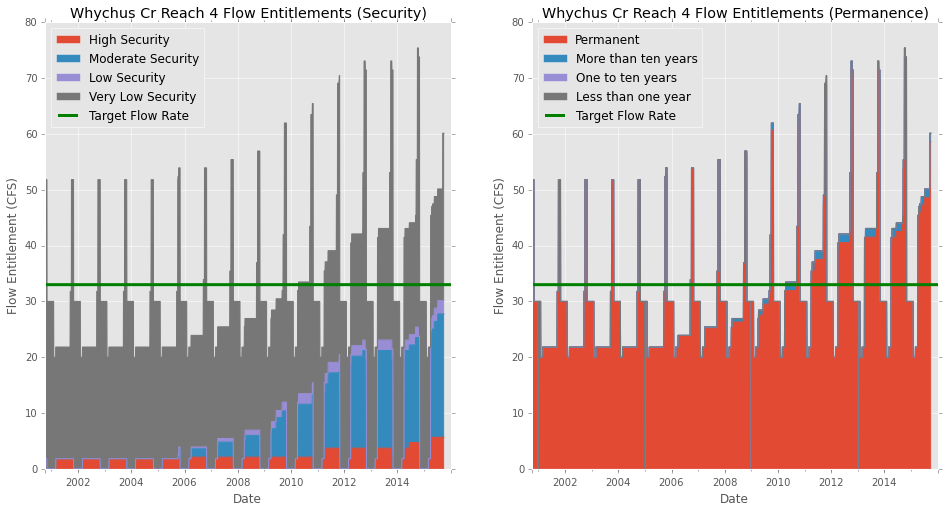

In [20]:
flow_series = flowdata['mean_daily_flow_cfs']
flow_series.name = "Recorded Volume"
target_series = flowdata['mean_daily_flow_cfs-target']
target_series.name = "Target Flow Rate"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
def plot_rates(result, columns, ax, title):
    result[columns].plot.area( 
        title=title,
        ax=ax)
    target_series.plot.line(ax=ax, color='g', linewidth=3, legend=True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Flow Entitlement (CFS)")

plot_rates(entitlements_classed_security_df, security_labels,
          ax=axes[0], title="Whychus Cr Reach 4 Flow Entitlements (Security)")
plot_rates(entitlements_classed_permanence_df, term_labels,
          ax=axes[1], title="Whychus Cr Reach 4 Flow Entitlements (Permanence)")

## Assessment 1: Annual Analysis

The rates are then integrated over water years to determine the entitled flow volumes, again classed by security and permanence. The figure below shows the entitled volumes compared to the actual flow volume and the target volume.

In [21]:
from waterkit.flow import analysis

flow_series = flowdata['mean_daily_flow_cfs']
flow_series.name = "Recorded Volume"
target_series = flowdata['mean_daily_flow_cfs-target']
target_series.name = "Target Volume"

security_data = [
    flow_series,
    target_series,
    entitlements_classed_security_df,
]

permanence_data = [
    flow_series,
    target_series,
    entitlements_classed_permanence_df,
]

cfs_to_afd = 1.9835
security_result = pd.concat(security_data, join='inner', axis=1)
permanence_result = pd.concat(permanence_data, join='inner', axis=1)
security_volume = analysis.integrate_annually(security_result) * cfs_to_afd
permanence_volume = analysis.integrate_annually(permanence_result) * cfs_to_afd

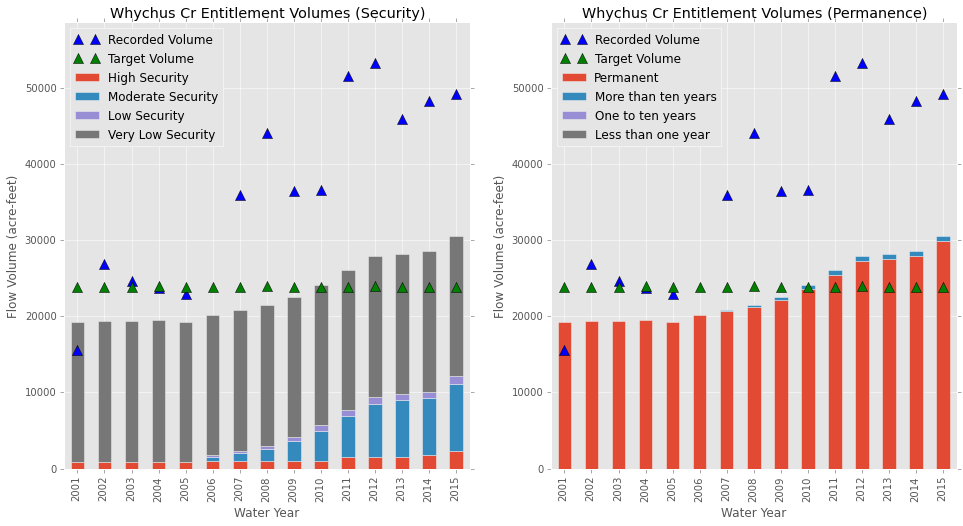

In [22]:
# Plot the two assessments side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
def plot_assessment(result, columns, ax, title):
    bars = result[columns].plot.bar(
        stacked=True,
        title=title,
        ax=ax)
    ax.plot(result[flow_series.name], 'm^', color='b', linewidth=3, markersize=10, label=flow_series.name)
    ax.plot(result[target_series.name], 'm^', color='g', linewidth=3, markersize=10, label=target_series.name)
    bar_lines, bar_labels = bars.get_legend_handles_labels()
    ax.legend(bar_lines, bar_labels, loc='best')
    ax.set_ylim(0, result.max().max() * 1.1)
    ax.set_xlabel("Water Year")
    ax.set_ylabel("Flow Volume (acre-feet)")
    
plot_assessment(security_volume, security_labels, axes[0],
    title="Whychus Cr Entitlement Volumes (Security)")
plot_assessment(permanence_volume, term_labels, axes[1],
    title="Whychus Cr Entitlement Volumes (Permanence)")

## Assessment 2: Entitlement During Flow Deficit

For the e-flow attainment indicator, the deficit statistics are calculated only on the days during which a flow deficit was measured. This assessment repeats the annual volume assessment, but restricts the volume calculations to days on which the e-flow target exceeded the actual flow. In addition, the volumes are normalized to the target volume. This was done to eliminate the effect of a decreasing target volume due to the fact that the number of deficit days is decreasing during the period of record. The plot below shows the results of this analysis, with all volumes normalized to the e-flow target volume.

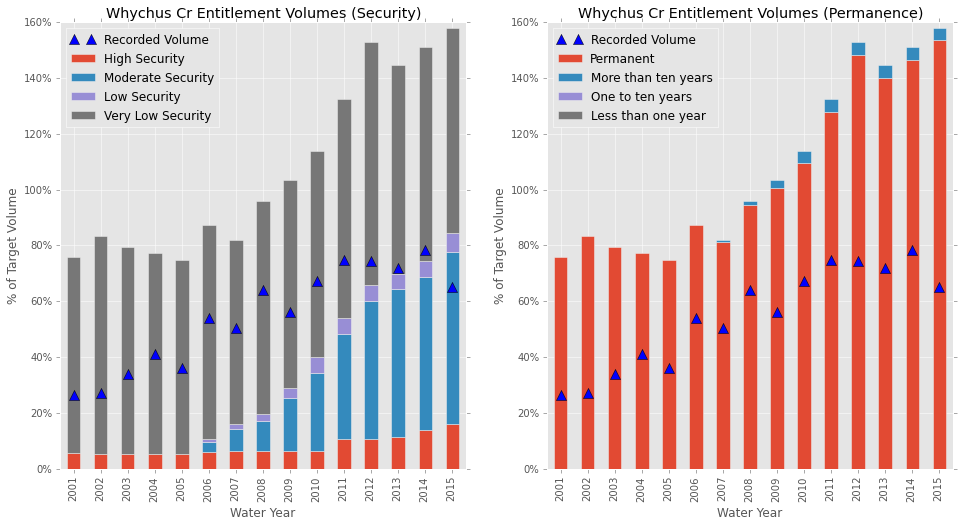

In [23]:
security_result_deficit = security_result[security_result["Target Volume"] > security_result["Recorded Volume"]]
permanence_result_deficit = permanence_result[permanence_result["Target Volume"] > permanence_result["Recorded Volume"]]

security_volume_deficit = analysis.integrate_annually(security_result_deficit) * cfs_to_afd
permanence_volume_deficit = analysis.integrate_annually(permanence_result_deficit) * cfs_to_afd

def normalize_to_column(df, column):
    return df.div(df[column], axis='index')

def bar_plot_assessment_normalized(result, columns, ax, title, xlabel="Water Year"):
    bars = result[columns].plot.bar(
        stacked=True,
        title=title,
        ax=ax)
    #result[[flow_series.name]].plot(
    #    ax=ax, linewidth=4, color="b")
    actual = ax.plot(
        result[flow_series.name],
        'm^',
        color='b',
        markersize=10,
        label=flow_series.name)
    bar_lines, bar_labels = bars.get_legend_handles_labels()
    ax.legend(bar_lines, bar_labels, loc='best')
    #ax.set_ylim(0, 1.0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("% of Target Volume")
    yvalues = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in yvalues])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
bar_plot_assessment_normalized(
    normalize_to_column(security_volume_deficit, "Target Volume"),
    security_labels, axes[0],
    title="Whychus Cr Entitlement Volumes (Security)")
bar_plot_assessment_normalized(
    normalize_to_column(permanence_volume_deficit, "Target Volume"),
    term_labels, axes[1],
    title="Whychus Cr Entitlement Volumes (Permanence)")

## Assessment 3: Critical Season Analysis

First, we look at the 7-day mean flows to see where the critical period lies:

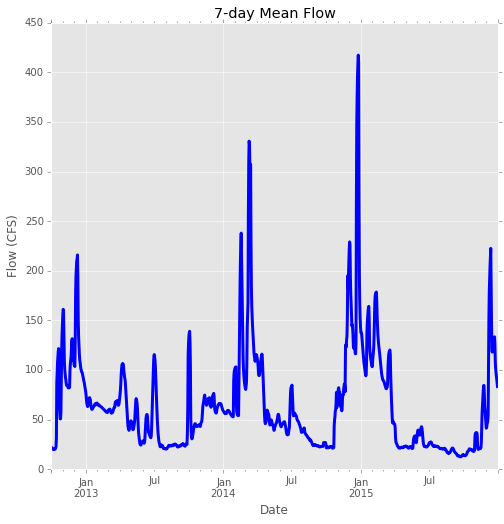

In [24]:
mean_flow = pd.rolling_mean(flowdata['mean_daily_flow_cfs'], 7)
mean_flow.name = "7-day flow mean"
ax = mean_flow[datetime(2012, 10, 1):].plot(figsize=(8, 8), linewidth=3, color='b', title="7-day Mean Flow")
ax.set_xlabel("Date")
ax.set_ylabel("Flow (CFS)")

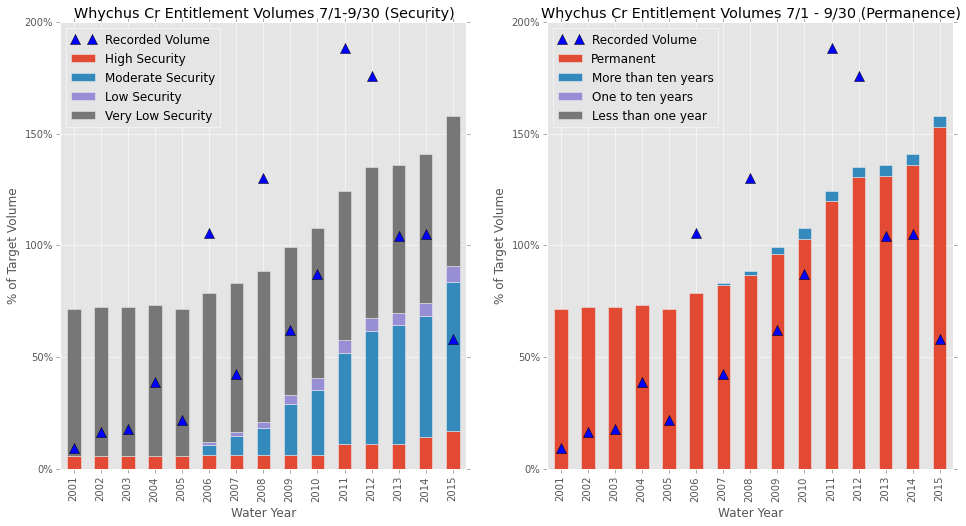

In [25]:
start_day = pd.Timestamp("7-1-2000").dayofyear
end_day = pd.Timestamp("9-30-2000").dayofyear

def restrict_season(frame, start_day, end_day):
    return frame[(frame.index.dayofyear >= start_day) & (frame.index.dayofyear <= end_day)]

security_result_seasonal = restrict_season(security_result, start_day, end_day)
permanence_result_seasonal = restrict_season(permanence_result, start_day, end_day)

security_volume_seasonal = analysis.integrate_annually(security_result_seasonal) * cfs_to_afd
permanence_volume_seasonal = analysis.integrate_annually(permanence_result_seasonal) * cfs_to_afd

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
bar_plot_assessment_normalized(
    normalize_to_column(security_volume_seasonal, "Target Volume"),
    security_labels, axes[0],
    title="Whychus Cr Entitlement Volumes 7/1-9/30 (Security)")
bar_plot_assessment_normalized(
    normalize_to_column(permanence_volume_seasonal, "Target Volume"),
    term_labels, axes[1],
    title="Whychus Cr Entitlement Volumes 7/1 - 9/30 (Permanence)")

## Assessment 4: Irrigation Season Analysis (4/1 - 10-31)

Per Bruce's request, this one performs the same analysis, but limits the volume calculation for each water year to encompass the irrigation season from 4/1 to 10/31. In addition, all volumes are normalized to the target volume for the same period. The volume integration is performed over calendar years rather than water years since the irrigation season spans the water year boundary.

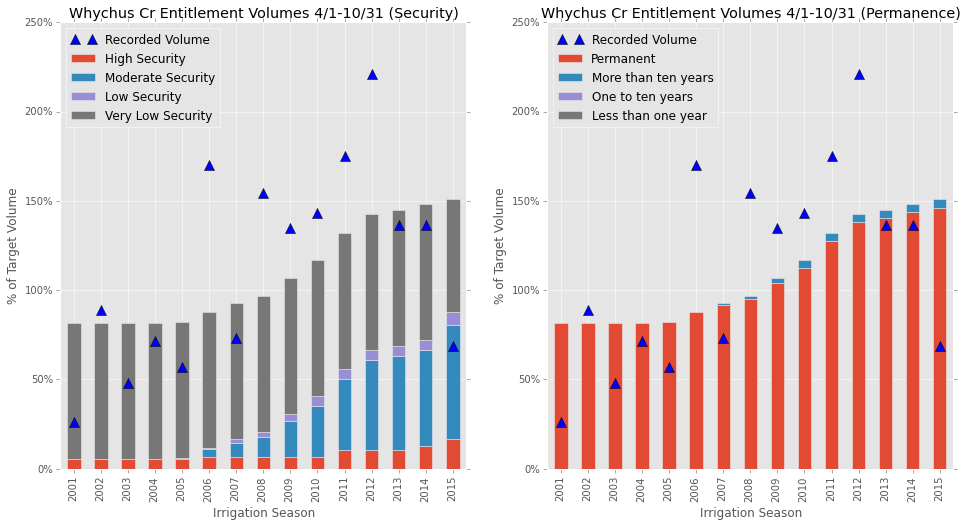

In [26]:
start_day = pd.Timestamp("4-1-2000").dayofyear
end_day = pd.Timestamp("10-31-2000").dayofyear

# Only take dates after 2001-01-01 below since we don't have a full record for the 2000 irrigation season.
security_result_irrigation = restrict_season(security_result[datetime(2001,1,1):], start_day, end_day)
permanence_result_irrigation = restrict_season(permanence_result[datetime(2001,1,1):], start_day, end_day)

# Integrate over calendar years rather than water years since the irrigation season spans water years.
security_volume_irrigation = security_result_irrigation.groupby(lambda x: x.year).sum() * cfs_to_afd
permanence_volume_irrigation = permanence_result_irrigation.groupby(lambda x: x.year).sum() * cfs_to_afd

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
bar_plot_assessment_normalized(
    normalize_to_column(security_volume_irrigation, 'Target Volume'),
    security_labels, axes[0],
    title="Whychus Cr Entitlement Volumes 4/1-10/31 (Security)",
    xlabel="Irrigation Season")
bar_plot_assessment_normalized(
    normalize_to_column(permanence_volume_irrigation, 'Target Volume'),
    term_labels, axes[1],
    title="Whychus Cr Entitlement Volumes 4/1-10/31 (Permanence)",
    xlabel="Irrigation Season")